In [1]:
from config import args
from pytorch_lightning import Trainer, loggers
from models import get_pl_model
from augmentations import get_transforms
from datasets import get_train_val_dataloaders

# Get augmentation

In [2]:
transform=get_transforms('none')

# Get data loaders

In [35]:
train_dataloader, val_dataloader = get_train_val_dataloaders(transform=transform)

TypeError: __init__() takes 2 positional arguments but 3 were given

# Get model

In [4]:
model = get_pl_model('baseline')

# Train model

In [5]:
model=model.train()
args.gpus = None # Remove this line if you actually have gpus

tb_logger = loggers.TensorBoardLogger(save_dir="logs/")
trainer = Trainer(gpus=args.gpus,
                  max_epochs=args.epochs, 
                  logger=tb_logger,
                  # accelerator=args.accelerator,
                  resume_from_checkpoint=args.checkpoint_path 
)
trainer.fit(model, train_dataloader, val_dataloader)

 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/lightning_logs

  | Name  | Type | Params
-------------------------------
0 | model | Unet | 24.4 M
-------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.745    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/guy/anaconda3/envs/CIL_Sleeplearning/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/guy/anaconda3/envs/CIL_Sleeplearning/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/guy/anaconda3/envs/CIL_Sleeplearning/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The number of training ba

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# Visualize

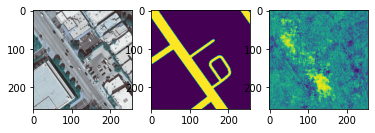

In [42]:
import matplotlib.pyplot as plt
import torch

img, mask = train_dataloader.dataset[6]
pred_mask=torch.sigmoid(model(torch.Tensor(img[None,:]))[0].detach()).numpy()
f, axarr = plt.subplots(1,3)
_ = axarr[0].imshow(img.transpose(1,2,0))
_ = axarr[1].imshow(mask.transpose(1,2,0))
_ = axarr[2].imshow(pred_mask.transpose(1,2,0))